## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# Import the essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

## Creating a class to hold data

In [2]:
Left_fit_data = None
Right_fit_data = None
Left_fit_array = None
Right_fit_array = None

class LaneDetection():
    def __init__(self):
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.right_best_fit = None
        self.left_best_fit = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        
        self.left_fit = None
        self.right_fit = None
        
        global Left_fit_data
        global Right_fit_data
        Left_fit_data = None
        Right_fit_data = None
        
        global Left_fit_array
        global Right_fit_array
        
        Left_fit_array = None
        Right_fit_array = None
        
        self.detected_poly = False
        self.detected_sliding = False
        
Example_laneDetection = LaneDetection()

### Camera calibration matrix and distortion coefficients given a set of chessboard images

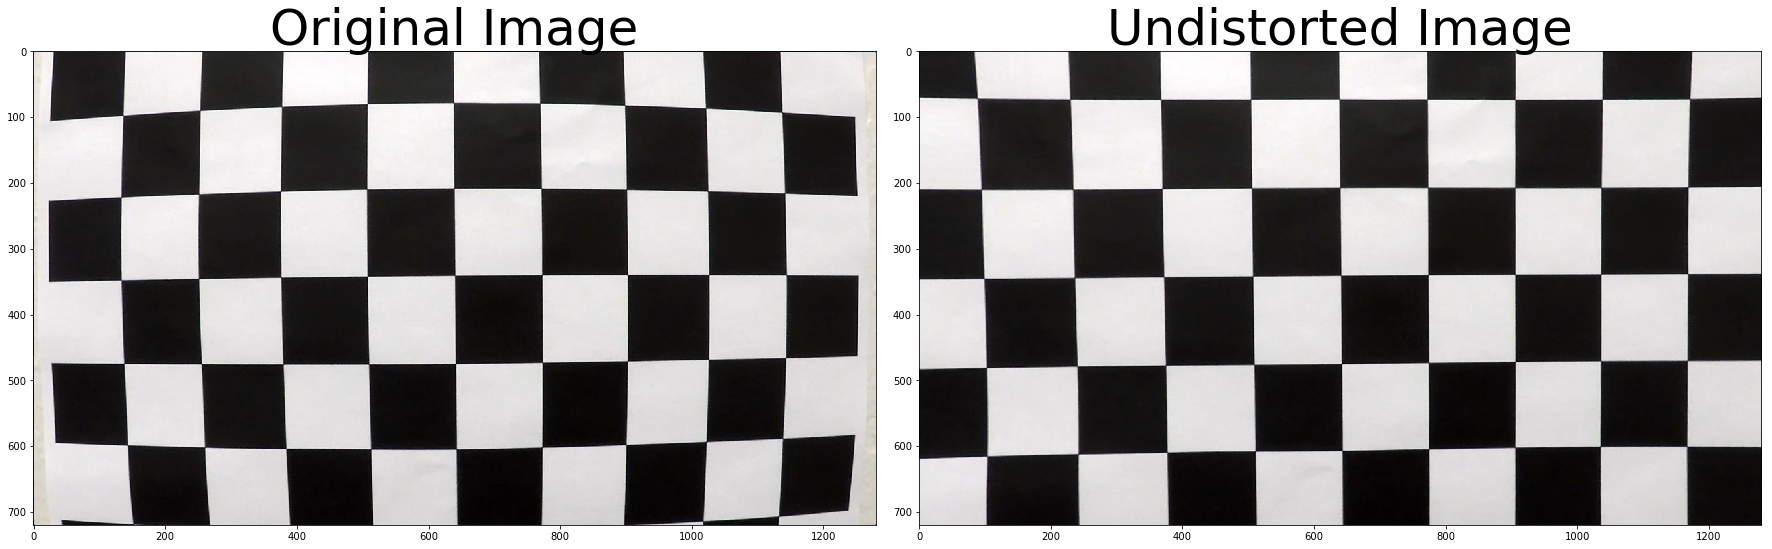

In [3]:
nx = 9
ny = 6

images = glob.glob('camera_cal/calibration*.jpg')

objpoints =[]
imgpoints =[]
    
# prepare object points
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Compute calibration matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

# Undistort function
def undistort_img(self,img):
    self.undist = cv2.undistort(img, mtx, dist, None, mtx)
    return self.undist

LaneDetection.undistort_img = undistort_img

image = mpimg.imread('camera_cal/calibration1.jpg')
undist_chessBoard = undistort_img(Example_laneDetection,image)

# Show example of original image and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_chessBoard)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply a distortion correction to raw images

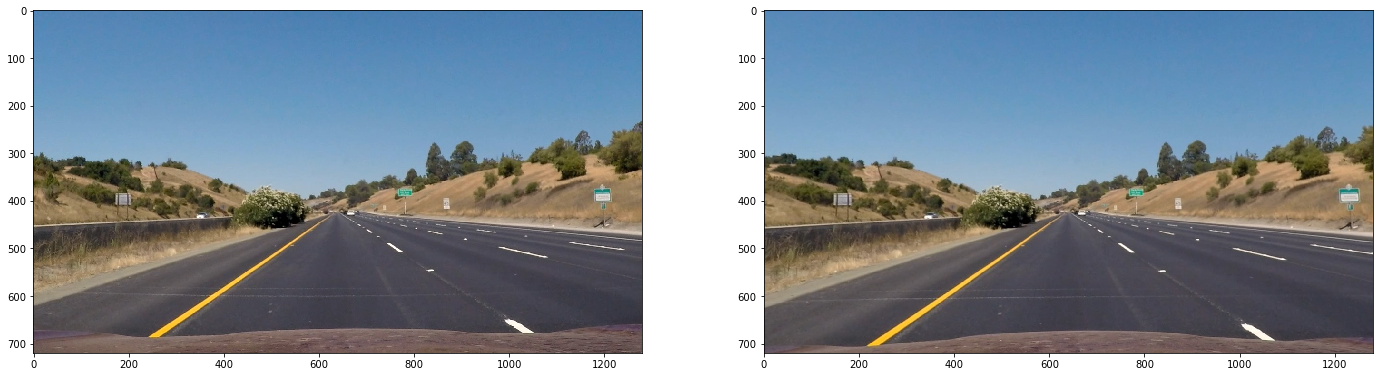

In [4]:
images = glob.glob('test_images/*.jpg')

for image in images:
    img = mpimg.imread(image)
    undist = undistort_img(Example_laneDetection,img)
    plt.imsave('output_images/undist_{}'.format(image),undist)

img = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistort_img(Example_laneDetection,img)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(undist)

### Use color transforms, gradients, etc., to create a thresholded binary image

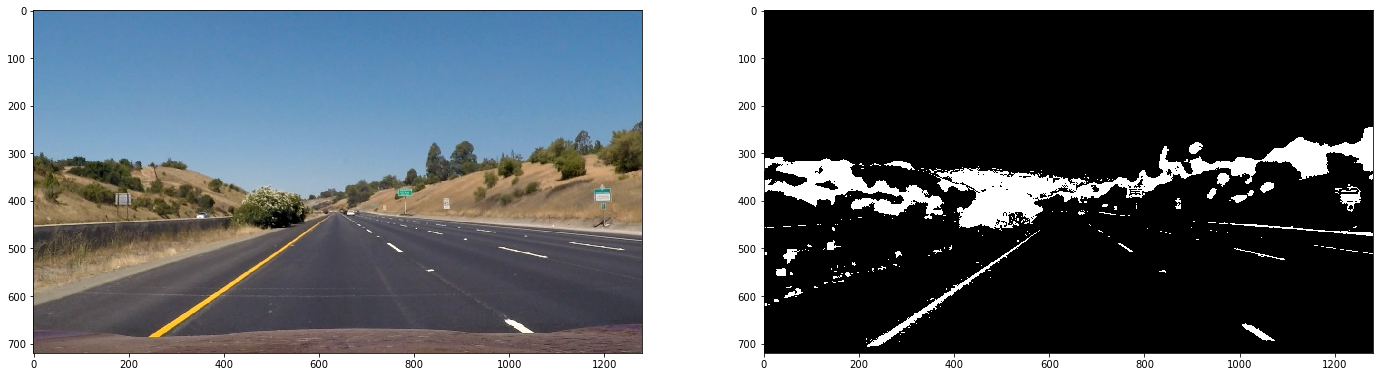

In [5]:
def color_grad_threshold(self,image):
    
    g = image[:,:,1]
    gbinary = np.zeros_like(g)
    gbinary[(g>180) & (g<=255)]=1
    # Sobelx and Sobely
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=15)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=15)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    thresh_min = 20
    thresh_max = 100
    
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx > thresh_min) & (scaled_sobelx < thresh_max)] = 1
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely > thresh_min) & (scaled_sobely < thresh_max)] = 1
    sxybinary = np.zeros_like(scaled_sobelx)
    sxybinary[(sybinary==1) & (sxbinary ==1)]=1
    
    # Gradient magnitude threshold
    abs_sobelxy =np.sqrt(np.square(sobelx)+np.square(sobely))
    
    mag_thresh_min = 30
    mag_thresh_max = 100
    
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    abs_sobelxybinary = np.zeros_like(sobelx)
    abs_sobelxybinary[(scaled_sobelxy > mag_thresh_min) & (scaled_sobelxy < mag_thresh_max)] = 1
    
    # Gradient direction threshold
    grad_direction = np.arctan2(abs_sobely,abs_sobelx)
    
    dir_thresh_min = 0.7
    dir_thresh_max = 1.3
    grad_direction_binary = np.zeros_like(sobely)
    grad_direction_binary[(grad_direction >= dir_thresh_min) & (grad_direction <= dir_thresh_max)] = 1
    
    # H and S threshold
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    s = hls[:,:,2]
    sbinary = np.zeros_like(s)
    sbinary[(s>150) & (s<=255)]=1
    hbinary = np.zeros_like(h)
    hbinary[(h>20)&(h<=50)]=1
    
    # Combine thresholds
    self.Sobelx_S_binary = np.zeros_like(s)
    self.Sobelx_S_binary[(gbinary==1)|(sbinary==1)|(hbinary==1)]=1
    
    return self.Sobelx_S_binary

LaneDetection.color_grad_threshold = color_grad_threshold

#Example
img = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistort_img(Example_laneDetection,img)
thresholded = color_grad_threshold(Example_laneDetection,Example_laneDetection.undist)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(thresholded,cmap='gray')

### Apply a perspective transform to rectify binary image ("birds-eye view")

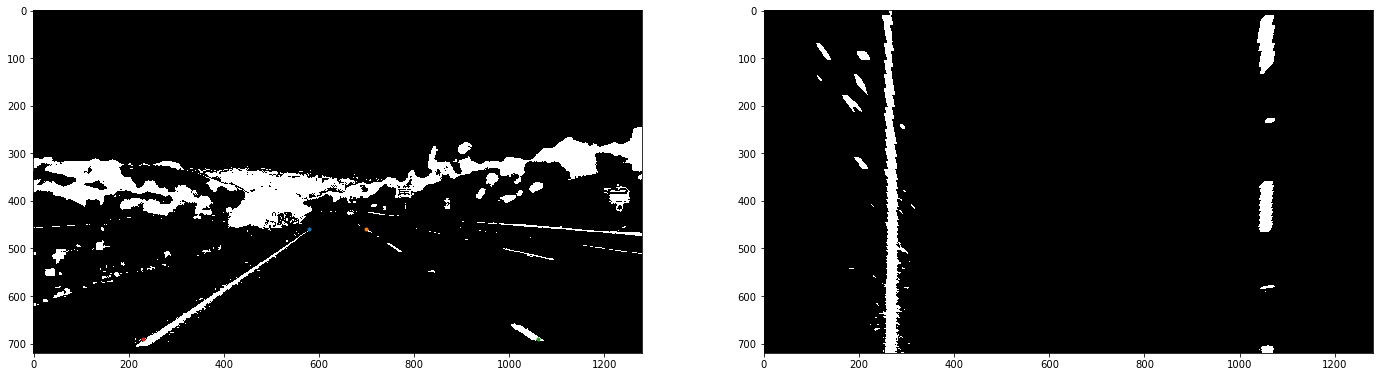

In [6]:
# Warp transform calculation for straight line image

source_vertices = np.float32([[580,460],[700,460],[1060,690],[230,680]])
dest_vertices = np.float32([[250,0],[1050,0],[1060,720],[230,720]])

M = cv2.getPerspectiveTransform(source_vertices,dest_vertices)
M_inv = cv2.getPerspectiveTransform(dest_vertices,source_vertices)

# Function for Perspective Transform
def birds_eye_view(self,image):
    img_size = (image.shape[1], image.shape[0])
    self.warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return self.warped

LaneDetection.birds_eye_view = birds_eye_view

warped_example = birds_eye_view(Example_laneDetection,thresholded)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(thresholded,cmap='gray')
ax1.plot(580,460,'.')
ax1.plot(700,460,'.')
ax1.plot(1060,690,'.')
ax1.plot(230,690,'.')
ax2.imshow(warped_example, cmap='gray')

### Detect lane pixels and fit to find the lane boundary - Sliding Window

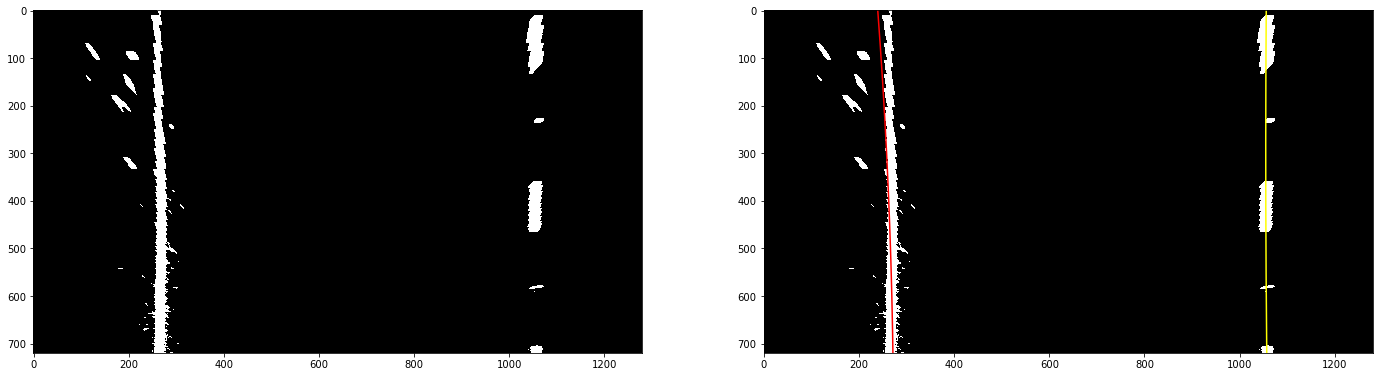

In [7]:
def sliding_window(self,warped_binary):
    
    bottom_half=warped_binary[warped_binary.shape[0]//2:,:]
    histogram = np.sum(bottom_half,axis=0)
    midpoint = np.int(warped_binary.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    
    self.offset = ((rightx_base-leftx_base)/2)-midpoint
    
    # Parameters for sliding window
    nwindows = 9 # number of windows
    margin = 100 #width of the windows
    minpix = 50 #minimum number of pixels found to recenter window
    window_height = warped_binary.shape[0]//nwindows
    
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    self.detected_sliding = False
    
    #current positions
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []
    
    global Left_fit_data
    global Right_fit_data

    for window in range(nwindows):
        # finding the window coordinates
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - (window)*window_height
    
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
    
        good_left_inds = np.nonzero((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high))[0]
        good_right_inds = np.nonzero((nonzerox<=win_xright_high)&(nonzerox>=win_xright_low)&
                                     (nonzeroy<=win_y_high)&(nonzeroy>=win_y_low))[0]
    
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if len(good_left_inds)>=minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>=minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    self.leftx = nonzerox[left_lane_inds]
    self.lefty = nonzeroy[left_lane_inds] 
    self.rightx = nonzerox[right_lane_inds]
    self.righty = nonzeroy[right_lane_inds]
    
    try:
        self.left_fit = np.polyfit(self.lefty,self.leftx,2)
        self.right_fit = np.polyfit(self.righty,self.rightx,2)
        self.detected_sliding = True
    except:
        self.left_fit = Left_fit_data
        self.right_fit = Right_fit_data
        self.detected_sliding = False
    
    return self.left_fit,self.right_fit,self.offset

LaneDetection.sliding_window = sliding_window

# Example for sliding window
left_fit,right_fit,offset = sliding_window(Example_laneDetection,Example_laneDetection.warped)
ploty = np.linspace(0, Example_laneDetection.warped.shape[0]-1, Example_laneDetection.warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((warped_example,warped_example,warped_example))*255

f,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(warped_example,cmap='gray')
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='red')
ax2.plot(right_fitx, ploty, color='yellow')

### Detect lane pixels and fit to find the lane boundary - Around Polynomial

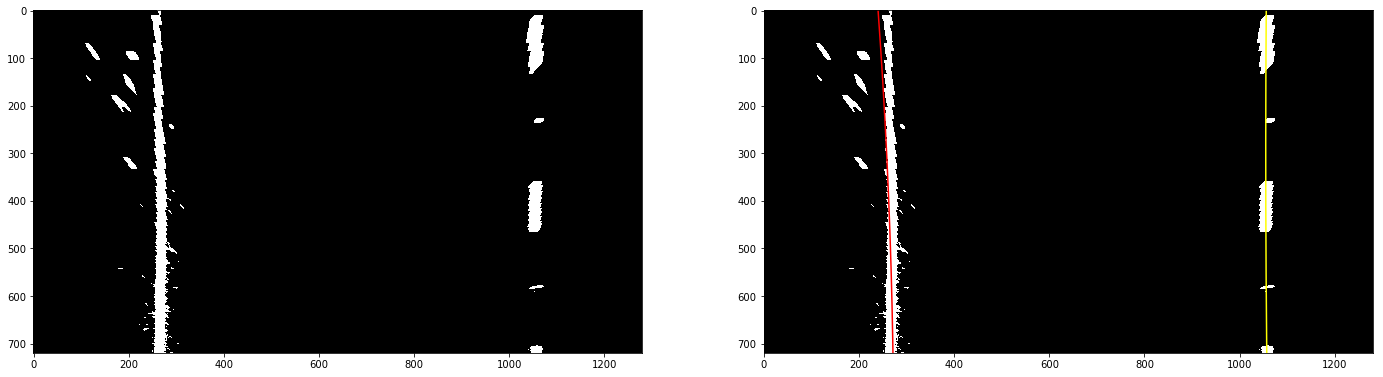

In [8]:
def polynomial_lane_detection(self,warped_binary,left_fit,right_fit):
        
    bottom_half=warped_binary[warped_binary.shape[0]//2:,:]
    histogram = np.sum(bottom_half,axis=0)
    midpoint = np.int(warped_binary.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    
    self.offset = ((rightx_base-leftx_base)/2)-midpoint
    
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_fitx = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_fitx = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]

    left_lane_inds = (nonzerox >= (left_fitx - margin)) & (nonzerox <= (left_fitx + margin))
    right_lane_inds = (nonzerox >= (right_fitx - margin)) & (nonzerox <= (right_fitx + margin))
    
    self.detected_poly = False
    
    #Extract the pixel positions
    self.leftx = nonzerox[left_lane_inds]
    self.rightx = nonzerox[right_lane_inds]
    self.lefty = nonzeroy[left_lane_inds]
    self.righty= nonzeroy[right_lane_inds]
    
    try:
        self.left_fit = np.polyfit(self.lefty,self.leftx,2)
        self.right_fit = np.polyfit(self.righty,self.rightx,2)
        self.detected_poly = True
        self.detected_sliding = False
    except:
        self.left_fit,self.right_fit,self.offset = self.sliding_window(warped_binary)
        self.detected_poly = False
    
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    self.left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    self.right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    return self.left_fit,self.right_fit,self.offset

LaneDetection.polynomial_lane_detection = polynomial_lane_detection
# Example for polynomial lane detection
left_fit_poly,right_fit_poly,offset_poly = polynomial_lane_detection(Example_laneDetection,Example_laneDetection.warped,
                                                                     Example_laneDetection.left_fit,
                                                                     Example_laneDetection.right_fit)
ploty = np.linspace(0, Example_laneDetection.warped.shape[0]-1, Example_laneDetection.warped.shape[0])
left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]

out_img = np.dstack((Example_laneDetection.warped,Example_laneDetection.warped,Example_laneDetection.warped))*255

f,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(Example_laneDetection.warped,cmap='gray')
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='red')
ax2.plot(right_fitx, ploty, color='yellow')

### Determine the curvature of the lane and vehicle position with respect to center.

In [9]:
def calculate_curvature(self,y_eval,left_fit,right_fit):
    
    # Define the conversion parameters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    A_left = left_fit[0]*(xm_per_pix/(ym_per_pix)**2)
    B_left = left_fit[1]*(xm_per_pix/ym_per_pix)
    
    A_right = right_fit[0]*(xm_per_pix/(ym_per_pix)**2)
    B_right = right_fit[1]*(xm_per_pix/ym_per_pix)

    self.left_curverad = ((1 +(2* A_left *y_eval*ym_per_pix+B_left)**2)**1.5)/np.absolute(2*A_left)
    self.right_curverad = ((1 +(2*A_right*y_eval*ym_per_pix+B_right)**2)**1.5)/np.absolute(2*A_right)
    
    return self.left_curverad,self.right_curverad

LaneDetection.calculate_curvature = calculate_curvature
#Example radius of curvature
y_eval=out_img.shape[0]
left_curverad,right_curverad = calculate_curvature(Example_laneDetection,y_eval,Example_laneDetection.left_fit,
                                                   Example_laneDetection.right_fit)
print(left_curverad,'m',right_curverad,'m')

4182.857243964425 m 13372.457625781863 m


### UnWarp the detected lane boundaries back onto the original image.

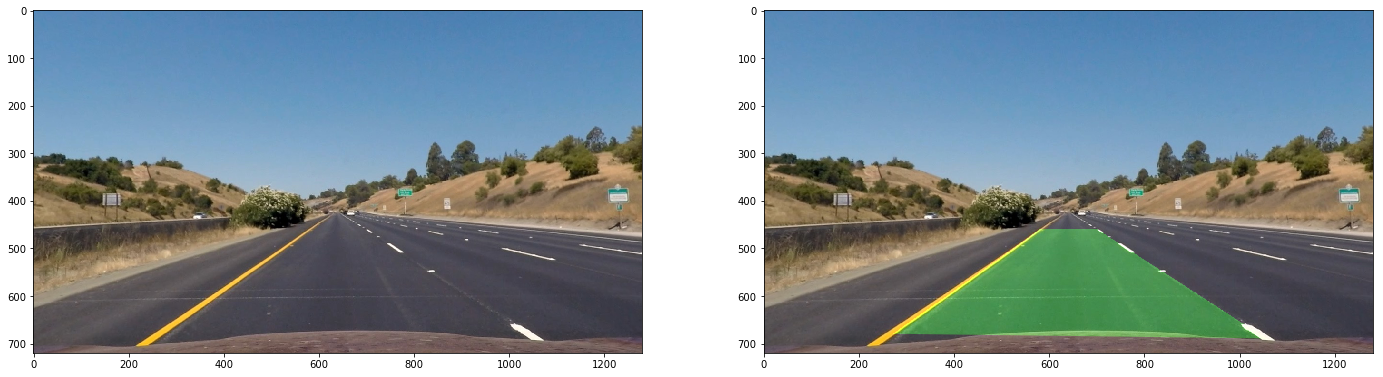

In [10]:
def unwarp(self,original_image,warped_binary,left_fit,right_fit):
    
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    self.mean_diff = np.mean(pts_left) - np.mean(pts_right)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, M_inv, (original_image.shape[1], original_image.shape[0])) 
    # Combine the result with the original image
    self.unwarped_result = cv2.addWeighted(original_image, 1, unwarped, 0.3, 0)
    
    return self.unwarped_result

LaneDetection.unwarp = unwarp

#Example output
final_output = unwarp(Example_laneDetection,Example_laneDetection.undist,Example_laneDetection.warped,Example_laneDetection.left_fit,
                      Example_laneDetection.right_fit)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(24,9))
ax1.imshow(Example_laneDetection.undist)
ax2.imshow(final_output)

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

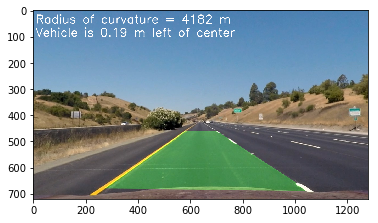

In [11]:
def add_info(self,unwarped,curverad,offset):
    
    input_image = unwarped
    offset_m = np.round(offset * (3.7/700),2)
    text_1 = 'Radius of curvature = {} m'.format(np.int(curverad))
    text_2 = 'Vehicle is {} m left of center'.format(offset_m)
    rc_added = cv2.putText(input_image, text_1, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    self.offset_added = cv2.putText(rc_added, text_2, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    return self.offset_added

LaneDetection.add_info = add_info

# Example for added info on the image
offset_added = add_info(Example_laneDetection,Example_laneDetection.unwarped_result,
                        Example_laneDetection.left_curverad,Example_laneDetection.offset)
plt.imshow(offset_added)

## Processing loop for every image

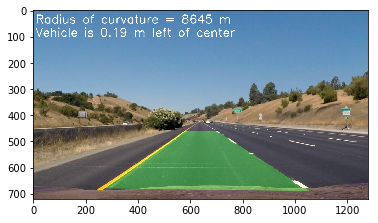

In [12]:
def advanced_lane_detection(self,image):
    
    undist = self.undistort_img(image)
    thresholded = self.color_grad_threshold(undist)
    warped_binary = self.birds_eye_view(thresholded)
    
    global Left_fit_data
    global Right_fit_data
    
    global Left_fit_array
    global Right_fit_array
    
    if (Left_fit_data is None) or (Right_fit_data is None):
        Left_fit_data,Right_fit_data,self.offset = self.sliding_window(warped_binary)
    else:
        Left_fit_data,Right_fit_data,self.offset = self.polynomial_lane_detection(warped_binary,Left_fit_data,Right_fit_data)
    
    if (Left_fit_array is None) or (Right_fit_array is None):
        Left_fit_array = Left_fit_data
        Right_fit_array = Right_fit_data
        self.right_best_fit = Left_fit_array
        self.left_best_fit = Right_fit_array
    elif (Left_fit_array.size==3) and (Right_fit_array.size==3):
        Left_fit_array= np.reshape((np.append(np.hstack(Left_fit_array),Left_fit_data)),(2,3))
        Right_fit_array=np.reshape((np.append(np.hstack(Right_fit_array),Right_fit_data)),(2,3))
        self.right_best_fit = np.sum(Right_fit_array,axis=0)/len(Right_fit_array)
        self.left_best_fit = np.sum(Left_fit_array,axis=0)/len(Left_fit_array)
    elif (len(Left_fit_array) < 12) or (len(Right_fit_array) <12):
        Left_fit_array= np.reshape((np.append(np.hstack(Left_fit_array),Left_fit_data)),(len(Left_fit_array)+1,3))
        Right_fit_array=np.reshape((np.append(np.hstack(Right_fit_array),Right_fit_data)),(len(Right_fit_array)+1,3))
        self.right_best_fit = np.sum(Right_fit_array,axis=0)/len(Right_fit_array)
        self.left_best_fit = np.sum(Left_fit_array,axis=0)/len(Left_fit_array)
    else:
        Left_fit_array = np.reshape((np.append((np.delete(np.hstack(Left_fit_array),[0, 1, 2])),Left_fit_data)),(12,3))
        Right_fit_array = np.reshape((np.append((np.delete(np.hstack(Right_fit_array),[0, 1, 2])),Right_fit_data)),(12,3))
        self.right_best_fit = np.sum(Right_fit_array,axis=0)/len(Right_fit_array)
        self.left_best_fit = np.sum(Left_fit_array,axis=0)/len(Left_fit_array)
        
    y_eval=image.shape[0]
    self.left_curverad,self.right_curverad = self.calculate_curvature(y_eval,self.left_best_fit,self.right_best_fit)
    Diff_curvature = self.left_curverad - self.right_curverad
    average_curverad = (self.left_curverad + self.right_curverad)/2
    self.unwarped = self.unwarp(image,warped_binary,self.left_best_fit,self.right_best_fit)
    self.lane_detected_output = self.add_info(self.unwarped,average_curverad,self.offset)
    return self.lane_detected_output


LaneDetection.advanced_lane_detection = advanced_lane_detection
# Example call
images = glob.glob('test_images/*.jpg')

#for image in images:
#    img = mpimg.imread(image)
#    lane_detected_output = advanced_lane_detection(Example_laneDetection,img)
#    plt.imsave('output_images/laneDetected_{}'.format(image),lane_detected_output)
obj1= LaneDetection()
img = mpimg.imread('test_images/straight_lines1.jpg')
lane_detected_output = advanced_lane_detection(obj1,img)
plt.imshow(lane_detected_output)

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Video detection

In [14]:
obj = LaneDetection()
lane_detected_output = 'test_output/project_video.mp4'
clip1 = VideoFileClip("project_video_test.mp4")
lane_detected_clip = clip1.fl_image(obj.advanced_lane_detection)
%time lane_detected_clip.write_videofile(lane_detected_output, audio=False)

[MoviePy] >>>> Building video test_output/project_video.mp4
[MoviePy] Writing video test_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:37<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output/project_video.mp4 

Wall time: 10min 40s


## Video output

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_detected_output))